In [137]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import time 

In [133]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                x_Y = U + 0.5
                # x_Y = [-1]*indiv + U + A + df.groupby(["indiv"]).A.mean()
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [123]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [124]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model = {}
    poly = PolynomialFeatures(1)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            x = temp_df[["L1_1", "A_1"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), poly.fit_transform(x)).fit(); 
        elif ii == 2: 
            x = temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # poly.fit_transform(x)).fit(); 
        else: 
            x = temp_df[train_columns]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # np.asarray(sm.add_constant())).fit(); 
        L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       poly.fit_transform(x)).fit(); 
    return(L1_model)

In [95]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    train_columns = ["L1", "L1_1", "L1_2", "A_1", "A_2", "A_3"]
    A_model = {}
    poly = PolynomialFeatures(1)
            
    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            x = temp_df[["L1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), sm.add_constant(x, has_constant = "add")).fit()
        elif ii == 1: 
            x = temp_df[["L1", "L1_1", "A_1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        elif ii == 2:
            x = temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        else: 
            x = temp_df[train_columns]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
    return(A_model)


In [131]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 
    
    L_model = covariate_model_creation(df, max_time)
    poly = PolynomialFeatures(1)

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    x = np.transpose(np.array([list(values[0]),[A_test[0]]*reps]))
    values[1] = L_model[1].predict(poly.fit_transform(x))
    #np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                # np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    
    p_v = sp.special.expit(values[1])
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    x = np.transpose(np.array([list(values[1]),list(values[0]), [A_test[1]]*reps, [A_test[0]]*reps]))
    values[2] = L_model[2].predict(poly.fit_transform(x))
                # np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                # np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                # [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = sp.special.expit(values[2]) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        x = np.transpose(np.array([list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps]))
        values[jj] = L_model[jj].predict(poly.fit_transform(x))
                     # np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     # *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     # list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     # [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = sp.special.expit(values[jj]) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = sp.special.expit(Y_exp)
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [7]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [8]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [9]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [10]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [11]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [140]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_effect_time = pd.DataFrame(columns = ["treatment_g1", "treatment_g0", "differenceg", 
                                            "treatment_dr1", "treatment_dr0", "differencedr",\
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

time_dr = 0 
time_g = 0 

alpha_model_right = [False]*12
s_model_right = [False]*12
alpha_model_good = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
    start_time = time.time()
     
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    # results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]
    time_g = time_g + time.time()-start_time
    
    start_time = time.time()
    for kk in range(0,max_time+1):
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    [treatdr1_bin, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    time_dr = time_dr + time.time() - start_time

    results_effect_time.loc[len(results_effect_time)+1] = [treatg1, treatg0, treatg1-treatg0, treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 
    
# results_effect_df2.to_csv("W_EFFECT_RESULTS2")
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.549639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593694


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.549724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588314


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.565639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590660


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.556276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595898


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.591414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603500


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.541439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599293


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.573633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613755


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.572175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.557245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578281


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.573936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587282


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.554971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603697


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.585811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.576763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.561912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.570393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601228

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.563631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600705

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.568427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619226

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.539729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.566081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601396

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.573919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.584704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.568024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.574769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610384

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.563886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598398

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.541509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.598815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.559204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.557379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600371

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.567301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596689

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.577269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.564651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.564691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.549064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.558754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600544

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.559901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.572710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.532032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610015

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.543538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.580611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.566091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.554167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.565554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605639

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.559533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587292

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.546587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.581048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.552665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.563800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.522494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573276

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.571134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.593719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.586835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595177

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.563502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.595074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605495

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.569621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.578279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.598028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.560499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597986

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.588448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.583045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.568080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.568938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.546554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596518

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.572252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.564596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.566694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.564021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592673

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.566480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618305

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.554598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597085

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.555713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576855

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.572790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.566881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.570308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.582149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.574688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.566759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.560940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605073

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.543380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575258

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.563357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594115

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.560918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.533032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.571692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593425

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.553473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573763

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.552381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.580914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.554773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.577496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601386

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.578475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.569649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.551398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.546661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600499

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.567863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611467

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.552156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.555659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584064

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.574433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.560023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.549558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.560062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.582198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.551110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593103

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.576191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.593164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.554579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.550147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59019

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.539597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.568341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59500

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.572228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.571512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.554664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.570615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59380

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.574844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.592493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.559019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.571350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62265

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.576601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.568372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.583755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.572013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59571

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.568348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58529

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.572193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.564643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.562790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59465

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.555554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.567199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.568124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.581100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58384

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.570697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.567314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.595297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.537383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.538227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.569447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60316

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.573717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.564756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.584732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.598042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.556246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.557972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55332

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.570675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.567968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60015

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.576391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59174

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.569211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.577509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57511

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.574003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.546818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.552617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.555891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.557414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59900

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.564060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.547256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.538964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.553065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.571344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.589189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.569096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59979

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.553104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59299

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.567754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61024

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.556490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.578076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.582735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.519539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59837

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.560821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.542573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.567733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.547782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59994

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.558748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.565137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60786

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.574605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60699

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.582750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60768

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.548482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59227

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.553563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.557481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.573041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.565699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60417

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.565805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58966

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.526282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.563411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.576773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58197

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.544948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.578742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.548930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.561781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.558340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60677

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.582945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.554546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59881

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.560763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58515

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.558803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.572885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.551968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.569353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.549417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.560518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.564307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.548874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.569826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.528003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.558763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.572594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59408

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.558656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61670

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.571444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.569053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.578731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59102

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.553686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59495

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.595262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.538895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.572276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.572055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60327

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.562521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.565264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60253

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.566985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58895

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.541946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.542585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.566540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.577761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57909

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.555488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.552618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.570252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57907

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.548855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.547473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.551806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.541308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.544323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.580378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58878

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.535011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.557886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.580342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.536746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.548443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59067

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.574540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.538574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.569937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.572778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.556265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.557294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.552198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60989

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.554600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.558882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.584354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60681

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.569705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.561247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.556148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.573594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.559420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.590795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58059

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.582021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.561620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58893

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.560460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58924

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.550509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56209

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.548283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.580266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.577649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.550194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.560335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.525963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59855

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.567770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55839

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.557564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.562652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61159

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.547598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58818

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.571010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.563065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.544792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.574138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.579784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.588428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.563633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.560864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58096

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.566049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.555560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.572666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.581116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.561923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.552347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.569635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.561882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.548096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.577167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.558357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.582788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.554136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.568044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.546044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.576131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59237

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.563532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60868

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.590694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.586349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.579318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.577036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.559948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.555072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.551395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.558444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59064

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.551164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.560209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.549446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.540248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.506902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.545698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.565239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.554060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.563740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.555845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59021

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.562129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57945

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.534157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.573472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.545136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59273

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.589489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.555663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.559510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58335

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.572509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.564604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60102

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.580325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.545246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.556658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.532370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.572064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.572824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61339

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.546101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.580265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.563673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59374

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.564498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.565902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62359

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.556847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.554896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60233

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.566812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.534364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60945

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.589963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.577385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.579383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58616

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.603311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.566708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.587200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.566282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.579475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.557581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.563580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.558448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.574246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60972

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.577835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.554524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.560634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.559609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.552088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57486

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.574630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.548441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59286

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.567878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59768

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.542629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.572710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.563693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.546683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61096

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.557786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.574199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.553755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58831

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.560768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.587953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.559849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.563192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59573

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.576369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59804

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.557500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.585235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.539623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.537403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.549040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60935

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.561884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.572056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.562858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58837

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.558086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61252

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.572933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.573299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60607

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.588063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58359

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.558506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.570030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.556144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.554641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.573530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.563053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61529

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.548851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60532

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.570425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59448

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.553503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.569892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61691

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.581166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.548907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.559271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.541609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.567276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.581526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.552601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61332

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.557626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.566678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62514

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.552399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.558133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.521771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59245

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.559520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60427

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.558192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.568983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.570093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.568232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.563843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.565899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.577485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61956

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.575966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.551814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58673

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.574211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.552284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61241

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.530346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.561664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.562221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61546

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.576023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.560386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.574105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.572516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.573990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.569173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60643

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.552950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60761

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.571419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58102

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.566923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.558018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60176

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.575920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61284

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.577440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61909

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.558276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.574396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.562121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.551589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57691

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.555302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.549467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.555704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.579795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60733

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.553229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.543057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58365

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.559542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.569657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.573314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.546843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.560309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.565433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60362

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.555569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59110

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.557903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59101

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.579080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59934

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.544265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60604

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.554576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.577002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60333

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.533840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.555294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.535530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.521895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.550230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.558866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.571053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.564786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.559354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.575831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.549406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.550785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58530

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.568731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.560815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.553787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58743

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.572957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.545483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61770

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.541880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.557152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59324

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.563287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61588

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.575471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58997

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.549089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.545665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.592680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.539753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.590874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.549541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.543645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.564764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61786

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.562065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.556705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.555818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.583678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59962

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.555969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.556926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.556212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.563413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.575216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.555333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.552059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.552807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.565643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.551529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.550494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60829

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.564449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.561328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58705

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.553011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.543920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57398

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.508439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61447

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.551395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.539356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58538

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.581210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59285

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.569312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60556

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.570515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.561007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.560640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.573930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.591779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.554800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.560813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.544030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59580

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.572485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.529930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.547643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.588460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58463

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.558123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.543537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59571

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.563300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.583911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.562510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.560198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.558686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60228

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.586580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59529

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.555283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60199

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.570815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.559045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59841

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.548196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.543413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.588877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60463

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.553325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60617

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.573905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61216

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.571532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.581340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.557355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57354

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.581155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.549238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.562302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.560015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.587320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.558882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.567432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57276

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.549762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.562146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.579927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.569934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59595

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.560676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61855

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.559621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.558624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.585278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.583176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.574551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58497

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.567160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.521061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.553755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58878

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.561012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59992

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.557975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61947

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.567734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57339

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.560048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.554033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61595

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.581170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.545420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.561967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.560904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.573899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.569157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61028

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.591225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.575150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.566752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.572029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.582899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60258

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.563301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.577015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.545637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.570548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.570471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.580797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.580558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58617

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.563142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.555529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.580264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.577657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.553421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.593890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.559558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.577556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57692

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.565337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.575254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58652

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.560585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60358

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.560546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.577161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60268

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.574249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58571

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.593183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61113

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.561681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58033

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.554634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.553077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59380

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.590499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60586

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.561820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.567309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.536900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.545947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59946

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.574058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58302

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.564436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56735

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.545551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.554724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.564599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.571694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59227

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.547512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.557733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59604

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.543709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.594968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59945

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.578075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.563803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.573426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.550225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.542372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.564903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.567216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60773

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.534595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.580652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61482

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.560665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.574349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.551682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.563760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.566739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60246

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.557943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61308

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.562390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60388

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.541447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.554229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.547107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.579775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.573585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59978

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.535320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.550692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58170

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.587770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.544077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.544410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.560272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.548162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.581503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.560982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.553217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.562356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.579009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.545414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.563768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57911

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.568585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.543609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.568744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.539438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.563584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.558651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57149

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.562833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60577

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.563733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58260

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.565725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.571326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.579869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59454

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.546675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.583680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.565925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.547836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60358

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.562395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57710

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.563952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.547406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.572839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.579321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.577711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59839

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.565098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59970

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.525101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59298

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.557433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.577263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61885

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.552940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58829

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.558136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59286

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.549537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60398

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.564976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.551912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.563599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.553502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.546500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.565073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.564738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60155

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.562858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.546825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.552333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.569215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58561

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.538927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.571764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60339

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.555364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.577496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.555381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.552894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60331

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.550968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60429

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.556586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.551364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.556026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.566367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59722

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.579829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57329

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.580024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.546791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.574375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59940

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.570275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.573366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59870

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.578953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.571295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58711

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.557690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61268

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.562913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60222

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.537358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59606

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.564830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.595768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.539836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59944

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.558852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.517300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60265

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.565825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.531354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60334

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.556560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61208

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.559472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59817

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.588411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.545707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.545656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.560970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61387

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.562078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60235

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.550807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58440

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.545454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58499

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.548567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59675

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.566300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.555213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.538935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.557193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.550486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.558112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59692

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.584595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.565707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59440

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.577086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.549061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59127

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.543258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59619

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.597382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.571824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.582010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56257

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.579461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58839

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.547748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61563

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.567514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.567599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60672

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.571210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.575052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.559062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.549434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.559981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.514779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60283

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.550405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.546254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.564627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.590446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.554644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.586820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.540663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59595

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.532837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57625

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.553491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60617

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.549616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.572416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60323

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.567267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58989

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.547922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.573108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.570792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61567

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.568494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.592716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60599

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.554871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58853

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.559677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.60041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.557187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.542862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59294

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.569959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.555976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.540304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.566132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.564048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.550227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.554740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.554010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60747

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.556241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.566160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.549158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.562130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57422

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.554549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.554414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58676

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.549770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.583544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.555519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.563719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.542353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60444

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.533539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.555330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62605

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.572762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60775

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.537696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59853

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.561197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61220

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.574353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.566656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.579990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61377

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.585166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.576128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60067

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.572832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.563950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62543

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.574218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.567531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.575035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.584953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.553986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.557907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.557838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.562621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.580422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.559824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59986

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.564548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59527

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.560484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.573891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.569205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.575179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59619

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.571146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61119

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.553577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.574794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.574244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.531660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.549608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.559949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.537268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.539856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.568178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.570417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.547654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61019

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.553167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61077

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.549506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.547429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.548927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.585042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.568346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57878

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.574999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60672

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.564875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.570115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.554914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.566575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.528088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.560929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.554642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.586654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.570461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.559789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61275

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.574832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.561344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.566178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.549545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.571159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.555145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.529612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.598432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60162

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.572534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60673

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.550468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.557887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.541596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58282

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.580331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.572875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58384

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.552349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.586377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.576609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59078

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.590132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60395

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.566622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.582381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62103

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.536293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.566946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61089

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.570308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.585380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.563192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.570771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60114

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.572083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60390

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.578196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61265

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.549915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.556526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.564735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.550110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.535237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60934

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.579974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.558825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.575086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.563644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.568840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.554123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.529817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.557935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.560151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.548798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60028

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.588740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.522672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.577658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.553691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.568951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.539478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.558009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61199

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.537032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.577062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.530954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.549441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60170

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.581104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.548051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59339

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.557261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.566994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.575757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.528376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.558268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.556902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.551485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.574454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58703

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.552413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60761

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.556040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61472

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.551454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.558344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.546304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.550974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.607643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.533160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.571311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.563931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.548521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.563165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.542915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59745

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.568355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.559939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60554

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.557541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58625

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.553678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61333

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.554234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.522623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61043

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.554198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.585393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.567450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57027

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.579717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.569367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59323

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.559938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.591666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.570912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61607

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.555694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.576478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.565209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.555335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62241

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.567864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.553108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.540120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.537238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.562702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.579773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.562361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.556035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59692

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.575513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62482

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.564197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.537084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61046

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.573839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.540827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59715

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.557347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.572905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.546989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.557266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.569985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61451

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.552086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.580893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63564

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.554227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.584179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58579

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.554085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.574761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.586891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.547451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.557294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.553484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.574824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.553979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57546

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.578009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.557178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.562193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.555899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.566278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.534238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.558056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60424

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.570805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.573332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.569388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.546478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60458

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.588924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.578222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.550048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62344

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.571561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61956

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.565890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.572802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.563881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.564755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.568442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58911

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.579079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61025

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.552343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.576916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.583440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61321

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.538951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.577997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59661

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.545896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.558901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.572547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.563533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59209

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.580539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.571298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.573493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59848

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.566247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.576928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.546488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.550030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.559301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.571568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.562376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59046

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.568513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.553858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60228

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.565498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.538173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.559795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59773

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.558161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59429

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.534623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.586532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58306

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.551343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.531034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.569253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59127

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.577893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.554525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60618

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.546981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.545138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.562838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.576590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.568417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.583169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [145]:
print(time_dr/1000)
print(time_g/1000)

2.0290913763046263
0.3791993415355682


In [1120]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [1219]:
print(np.mean(results_effect_df2.differenceg) +1.96*np.sqrt(np.var(results_effect_df2.differenceg)/1000))
print(np.mean(results_effect_df2.differencedr) +1.96*np.sqrt(np.var(results_effect_df2.differencedr)/1000))
# results_effect_df2.head(100)

5.12580700345e-08
0.190098670895


In [1215]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer2/0 or inside your plot.ly account where it is named 'multiple-subplots'


In [1214]:
# plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
# from plotly import tools

results_effect_df.head()

trace1 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differencedr, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_effect_df.corrYL1,
    y=results_effect_df.differencedr, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_effect_df.corrAL1,
    y=results_effect_df.differencedr, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differenceg, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_effect_df.corrYL1,
    y=results_effect_df.differenceg, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_effect_df.corrAL1,
    y=results_effect_df.differenceg, 
    mode = "markers"
)




# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
fig.append_trace(trace4, 1, 2)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.025, 0.025])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.025, 0.025])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.025, 0.025])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy W/Effect')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='effect-multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



In [ ]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [930]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(np.absolute(results_good)))
print(np.mean(np.absolute(results_sbad)))
print(np.mean(np.absolute(results_alphabad)))
print(np.mean(np.absolute(results_bothbad)))
print(np.mean(np.absolute(results_good))-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.0266668559976
0.0298775255461
0.0304365475804
0.133435414522
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [935]:
# print(np.var(np.absolute(results.good)))
# print(np.var(np.absolute(results.sbad)))
# print(np.var(np.absolute(results.alphabad)))
# print(np.var(np.absolute(results.bothbad)))
# print(np.mean(np.absolute(results.good))-1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))), np.mean(np.absolute(results.good)) + 1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
# print(np.nanmean(np.absolute(results.sbad))- 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))), np.nanmean(np.absolute(results.sbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
# print(np.nanmean(np.absolute(results.alphabad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))), np.nanmean(np.absolute(results.alphabad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
# print(np.nanmean(np.absolute(results.bothbad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))), np.nanmean(np.absolute(results.bothbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

print(np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
print(np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
print(np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
print(np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

0.00387184465233
0.00409528321424
0.00420712587666
0.035504333813


In [929]:
from scipy import stats 
stats.ttest_ind(np.absolute(results.good),np.absolute(results.sbad))

Ttest_indResult(statistic=-0.55817928030626629, pvalue=0.57931640129713557)

In [1064]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)
    
len(s_model_wrong_no[0])

12

In [1098]:
s_model_wrong_no3 = np.empty((10, 0)).tolist()
alpha_model_wrong_no3 = np.empty((10, 0)).tolist()

s_model_wrong_no2[0] = list([0,0,0])+list([True,False,True,False,True,False,True,False, True])
s_model_wrong_no2[1] = list([0,0,0])+list([False,True,False,True,False,True,False, True,False])
alpha_model_wrong_no2[0] = 1-np.array(s_model_wrong_no2[0]).astype(int)
alpha_model_wrong_no2[1] = 1-np.array(s_model_wrong_no2[1]).astype(int)
len(s_model_wrong_no2)

s_model_wrong_no3[0] = list([1,1,1]) + list([False]*9)
alpha_model_wrong_no3[0] = 1-np.array(s_model_wrong_no3[0])

In [1103]:
s_model_wrong_no

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, True, True, True, True, True, True, True, True, False],
 [0, 0, 0, True, True, True, True, True, True, True, False, False],
 [0, 0, 0, True, True, True, True, True, True, False, False, False],
 [0, 0, 0, True, True, True, True, True, False, False, False, False],
 [0, 0, 0, True, True, True, True, False, False, False, False, False],
 [0, 0, 0, True, True, True, False, False, False, False, False, False],
 [0, 0, 0, True, True, False, False, False, False, False, False, False],
 [0, 0, 0, True, False, False, False, False, False, False, False, False],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1099]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 25

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df3 = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, 1): 
        # print(jj) 
        for kk in range(0,max_time+1):
            # print(kk)
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no3[jj][kk])
            # alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df3.loc[len(dr_test_df3)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        # [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # try: 
            # result = treatdr1 - treatdr0 
        # except: 
            # result = float("nan")
        
        # dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1054]:
# dr_test_df.to_csv("Multiple_Robust_Test25")
dr_test_df = pd.read_csv("Multiple_Robust_Test100")
dr_test_df2 = dr_test_df 
dr_test_df2.difference = np.absolute(dr_test_df2.difference)
dr_test_df2 = dr_test_df2[~np.isnan(dr_test_df2.difference)]
dr_test_df2.expect[dr_test_df2.expect == "yes"]  = "after_"
dr_test_df2.expect[dr_test_df2.expect == "no"]  = "before_"
dr_test_df2["which_mod"] = dr_test_df2["which_mod"].astype(str)
dr_test_df2["label"] = dr_test_df2.expect + dr_test_df2["which_mod"]
dr_test_df2.head()
# np.unique(dr_test_df2.label)

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k

Unnamed: 0  iter   expect which_mod  treatment_1  treatment_0  difference  \
0           1   0.0  before_       0.0     0.717188     0.736913    0.019725   
1           2   0.0   after_       0.0     0.717188     0.736913    0.019725   
2           3   0.0  before_       1.0     0.708196     0.732696    0.024500   
3           4   0.0   after_       1.0     0.720298     0.739571    0.019273   
4           5   0.0  before_       2.0     0.709148     0.733728    0.024579   

        label  
0  before_0.0  
1   after_0.0  
2  before_1.0  
3   after_1.0  
4  before_2.0

In [1082]:
s_model_wrong_no2[0]

[0, 0, 0, True, False, True, False, True, False, True, False, True]

In [1101]:
dr_test_df3.difference = np.absolute(dr_test_df3.difference)
# np.sqrt(dr_test_df4.groupby(["which_mod"]).difference.var()/25)
dr_test_df3.groupby(["which_mod"]).difference.mean()

which_mod
0.0    0.189957
Name: difference, dtype: float64

In [1087]:
dr_test_df2.groupby(["expect", "which_mod"]).difference.mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1058]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dr_test_df2.difference,     # Data
                          groups=dr_test_df2.label,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [1104]:
dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1112]:
s_model_wrong_yes

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1110]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [909]:
len(results)

25

In [937]:
trace1 = go.Box(
    y=np.absolute(results_good), 
    name = "Both Correct"
)
trace2 = go.Box(
    y=np.absolute(results_sbad), 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=np.absolute(results_alphabad), 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=np.absolute(results_bothbad), 
    name = "Both Misspecified"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    showlegend=False
)
py.iplot(data, filename='boxplot2')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [111]:
## TESTING NATURAL COUSE 
def natural_course_test(df): 
    max_time = 11
    indiv = 10000
    results_mean_df = pd.DataFrame(columns = list(df))
    results_var_df = pd.DataFrame(columns = list(df))
    Y_model = Y_model_creation(df, max_time)
    L_model = covariate_model_creation(df, max_time)
    A_model = treatment_model_creation(df, max_time)
    poly = PolynomialFeatures(1)
    poly2 = PolynomialFeatures(1)

    new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
    for ii in range(0, max_time+1): 
        # print(ii)
        if ii == 0: 
            L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

            A = A_model[ii].predict(sm.add_constant(L, has_constant='add'))

            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 1: 
            y = np.transpose(np.array([new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 2: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                    new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                    new_df[new_df["time"] == ii-2].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        else: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                     new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                      new_df[new_df["time"] == ii-3].A]))
            
            L = L_model[ii].predict(poly2.fit_transform(y))
            
            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, new_df[new_df["time"] == ii-3].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])
    for kk in range(1,max_time+1):
        new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
        new_df["A_"+str(kk)] = new_df.A.shift(kk)

    small_df = new_df[new_df["time"] == 11.0]
    cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
    small_df = small_df[cols]
    p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
    new_df.Y[new_df["time"] == 11.0]= np.random.binomial(n=1, p = sp.special.expit(p_Y)).astype(int)
    return(new_df)

In [116]:
indiv = 1000 
max_time = 11 
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697,  0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635 , 0.20497534 , 0.10442911]
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
x = natural_course_test(df)
print(stats.ttest_ind(df[df["time"] == max_time].Y,x[x["time"] == max_time].Y, equal_var=False))
print(stats.ttest_ind(df.A, x.A, equal_var=False))
print(stats.ttest_ind(df.L1, x.L1, equal_var=False))

Optimization terminated successfully.
         Current function value: 0.534935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465777
  

In [117]:
np.mean(df)

A          0.842333
L1         0.824500
U          0.533759
Y          0.753000
indiv    499.500000
time       5.500000
L1_1       0.824485
A_1        0.842320
L1_2       0.824471
A_2        0.842390
L1_3       0.824456
A_3        0.842461
L1_4       0.824441
A_4        0.842447
L1_5       0.824427
A_5        0.842434
L1_6       0.824412
A_6        0.842421
L1_7       0.824398
A_7        0.842408
L1_8       0.824383
A_8        0.842395
L1_9       0.824368
A_9        0.842382
L1_10      0.824354
A_10       0.842452
L1_11      0.824339
A_11       0.842439
dtype: float64

In [118]:
np.mean(x)

A           0.850699
L1          0.825746
Y           0.764600
indiv    4999.500000
time        5.500000
L1_1        0.825746
A_1         0.850699
L1_2        0.825746
A_2         0.850699
L1_3        0.825746
A_3         0.850698
L1_4        0.825746
A_4         0.850698
L1_5        0.825746
A_5         0.850698
L1_6        0.825747
A_6         0.850698
L1_7        0.825747
A_7         0.850698
L1_8        0.825747
A_8         0.850698
L1_9        0.825747
A_9         0.850698
L1_10       0.825747
A_10        0.850698
L1_11       0.825747
A_11        0.850698
dtype: float64

In [119]:
np.mean(x)-1.96*np.sqrt(np.var(x)/10000)

A           0.849725
L1          0.823747
Y           0.756285
indiv    4942.919674
time        5.432340
L1_1        0.823747
A_1         0.849725
L1_2        0.823748
A_2         0.849725
L1_3        0.823748
A_3         0.849725
L1_4        0.823748
A_4         0.849725
L1_5        0.823748
A_5         0.849725
L1_6        0.823748
A_6         0.849725
L1_7        0.823748
A_7         0.849725
L1_8        0.823748
A_8         0.849725
L1_9        0.823749
A_9         0.849725
L1_10       0.823749
A_10        0.849724
L1_11       0.823749
A_11        0.849724
dtype: float64

In [120]:
np.mean(x)+1.96*np.sqrt(np.var(x)/10000)

A           0.851672
L1          0.827744
Y           0.772915
indiv    5056.080326
time        5.567660
L1_1        0.827744
A_1         0.851672
L1_2        0.827745
A_2         0.851672
L1_3        0.827745
A_3         0.851672
L1_4        0.827745
A_4         0.851672
L1_5        0.827745
A_5         0.851672
L1_6        0.827745
A_6         0.851672
L1_7        0.827745
A_7         0.851672
L1_8        0.827745
A_8         0.851672
L1_9        0.827746
A_9         0.851672
L1_10       0.827746
A_10        0.851672
L1_11       0.827746
A_11        0.851672
dtype: float64

In [1576]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

NameError: name 'results_dr_df' is not defined

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

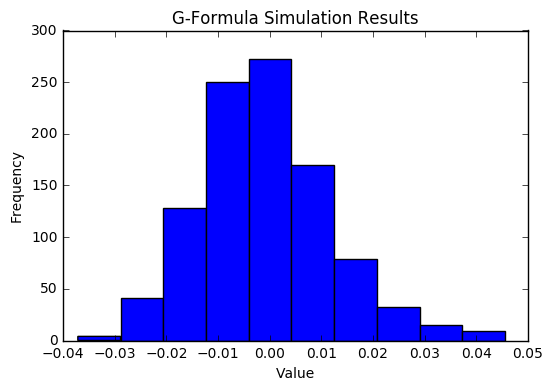

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

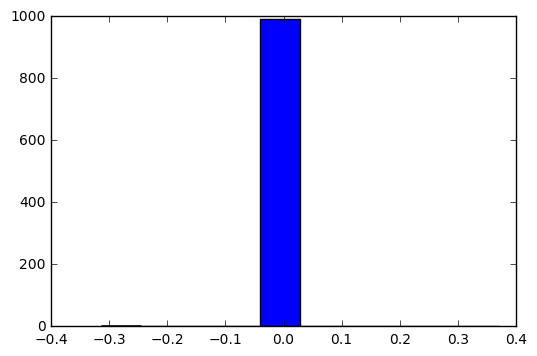

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [938]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

In [1136]:
results_effect_df2

trace1 = go.Histogram(
    x=results_effect_df2.differenceg,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_effect_df2.differencedr,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram_weffect')

In [942]:
print(np.mean(np.absolute(results_dr_bin_df.difference)))
print(np.mean(np.absolute(results_g_form_df.difference)))

0.030767222441063457
0.015947726700425487


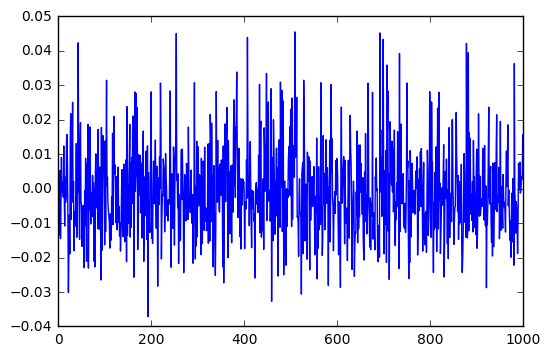

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

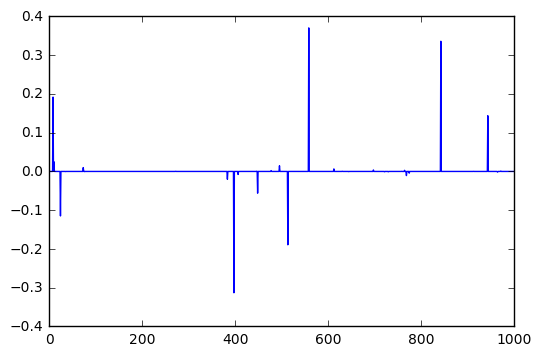

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001